In [77]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import pathlib
import numpy as np
import networkx
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
import shapely

# Storm Forecasts & Track
Storm forecasts and historical track will be published for each in-game day.

The forecasts represent model predictions for where the hurricane might be at the given timestamp.

The storm track represents the true path that the storm took in the past.

In [78]:
#input file
file_forecast = 'https://files.bwsi-remote-sensing.net/data/final_2024/day2/day2_forecasts_2024.geojson'

In [79]:
# Forecasts
forecast = gpd.read_file(file_forecast)

In [80]:
random_color = lambda: np.random.random(3)

In [81]:
# look at the forecasts
forecast

,prediction,forecastHour,datetime,maxWinds,category,geometry
0,1,12,2023-08-03 14:00:00,90,2,POINT (-71.08364 40.10039)
1,1,24,2023-08-04 02:00:00,100,3,POINT (-71.20753 40.57195)
2,1,36,2023-08-04 14:00:00,100,3,POINT (-71.57037 41.03901)
3,1,48,2023-08-05 02:00:00,85,2,POINT (-71.56239 41.78819)
4,1,60,2023-08-05 14:00:00,90,2,POINT (-71.82221 43.03099)
...,...,...,...,...,...,...
155,20,48,2023-08-05 02:00:00,85,2,POINT (-71.31454 42.18478)
156,20,60,2023-08-05 14:00:00,90,2,POINT (-71.45722 44.98515)
157,20,72,2023-08-06 02:00:00,70,1,POINT (-71.66635 43.23327)
158,20,96,2023-08-07 02:00:00,55,0,POINT (-69.51318 43.31826)


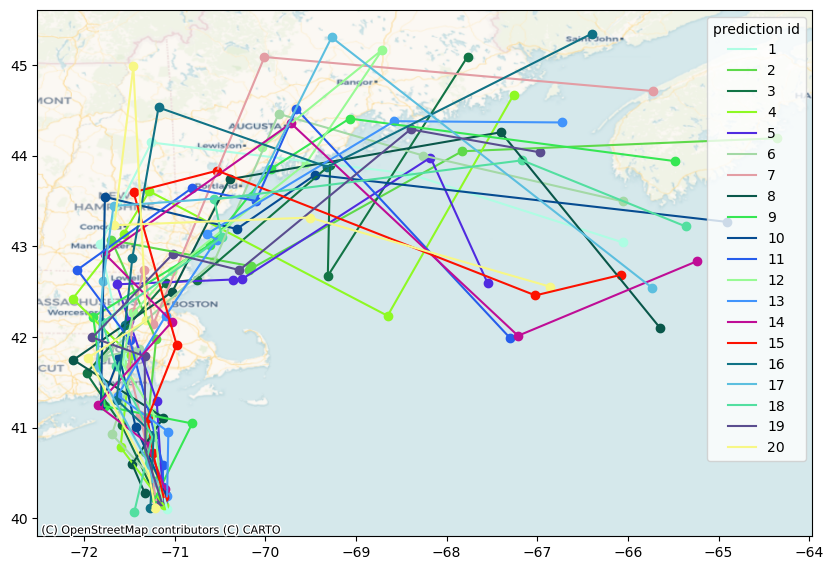

In [82]:
# each forecast report has a number of possible hurricane routes
# they are identified by the prediction column
fig, ax = plt.subplots(1, 1, figsize=(10,10))
for pred_id, pred in forecast.groupby('prediction'):
    c = random_color()
    pred.plot(color=c, ax=ax)
    line_to_plot = LineString(pred.geometry.values)
    ax.plot(line_to_plot.xy[0], line_to_plot.xy[1], color=c, label=f'{pred_id}')
ax.legend(title='prediction id')
ctx.add_basemap(ax,
               crs=forecast.crs,
               source=ctx.providers.CartoDB.Voyager
              )

In [83]:
#put it in meters
forecast_utm = forecast.to_crs(forecast.estimate_utm_crs())
                 
forecast_utm["x"] = forecast_utm.geometry.x
forecast_utm["y"] = forecast_utm.geometry.y

forecast_utm.head()

,prediction,forecastHour,datetime,maxWinds,category,geometry,x,y
0,1,12,2023-08-03 14:00:00,90,2,POINT (322394.961 4440980.099),322394.960549,4.440980e+06
1,1,24,2023-08-04 02:00:00,100,3,POINT (313140.004 4493583.267),313140.004130,4.493583e+06
2,1,36,2023-08-04 14:00:00,100,3,POINT (283945.201 4546270.909),283945.200787,4.546271e+06
3,1,48,2023-08-05 02:00:00,85,2,POINT (287078.802 4629433.64),287078.801597,4.629434e+06
4,1,60,2023-08-05 14:00:00,90,2,POINT (270075.519 4768121.598),270075.518732,4.768122e+06


In [84]:
#centroids
centroid_utm = (forecast_utm
     .groupby('forecastHour', as_index=False)
     [['x','y']]
     .mean()
     .assign(geometry = lambda df : gpd.points_from_xy(x=df.x,y=df.y, crs=forecast_utm.crs ))
    )


centroid_utm.head()

,forecastHour,x,y,geometry
0,12,314346.703924,4.455764e+06,POINT (314346.704 4455763.706)
1,24,305864.389409,4.524859e+06,POINT (305864.389 4524859.345)
2,36,285633.700720,4.607799e+06,POINT (285633.701 4607798.983)
3,48,284504.416098,4.676135e+06,POINT (284504.416 4676135.409)
4,60,330505.719328,4.774917e+06,POINT (330505.719 4774917.232)


In [85]:
#distances between points and centroids
dist_gdf = (forecast_utm
 .merge(centroid_utm[['forecastHour','geometry']], how='left', on='forecastHour', suffixes=['_orig', '_cent'])
 .assign(radius_m = lambda df: df.geometry_orig.distance(df.geometry_cent))
)

dist_gdf

,prediction,forecastHour,datetime,maxWinds,category,geometry_orig,x,y,geometry_cent,radius_m
0,1,12,2023-08-03 14:00:00,90,2,POINT (322394.961 4440980.099),322394.960549,4.440980e+06,POINT (314346.704 4455763.706),16832.393435
1,1,24,2023-08-04 02:00:00,100,3,POINT (313140.004 4493583.267),313140.004130,4.493583e+06,POINT (305864.389 4524859.345),32111.175494
2,1,36,2023-08-04 14:00:00,100,3,POINT (283945.201 4546270.909),283945.200787,4.546271e+06,POINT (285633.701 4607798.983),61551.238058
3,1,48,2023-08-05 02:00:00,85,2,POINT (287078.802 4629433.64),287078.801597,4.629434e+06,POINT (284504.416 4676135.409),46772.670330
4,1,60,2023-08-05 14:00:00,90,2,POINT (270075.519 4768121.598),270075.518732,4.768122e+06,POINT (330505.719 4774917.232),60811.099225
...,...,...,...,...,...,...,...,...,...,...
155,20,48,2023-08-05 02:00:00,85,2,POINT (308865.942 4672885.68),308865.941814,4.672886e+06,POINT (284504.416 4676135.409),24577.320302
156,20,60,2023-08-05 14:00:00,90,2,POINT (306283.229 4984238.682),306283.228859,4.984239e+06,POINT (330505.719 4774917.232),210718.291801
157,20,72,2023-08-06 02:00:00,70,1,POINT (283489.611 4790171.328),283489.611211,4.790171e+06,POINT (385165.94 4821696.352),106451.411126
158,20,96,2023-08-07 02:00:00,55,0,POINT (458388.447 4796285.908),458388.447236,4.796286e+06,POINT (534873.999 4858884.756),98836.508400


In [86]:
radii = dist_gdf.groupby("forecastHour", as_index=False)[["radius_m"]].mean()
radii

,forecastHour,radius_m
0,12,11414.336620
1,24,26101.544005
2,36,36586.992366
3,48,46318.580113
4,60,62823.928192
5,72,75240.986720
6,96,106258.000769
7,120,134182.086177


In [87]:
#.pipe switches the grouped dataframe to a geodataframe
forecast_radius_m_utm = (centroid_utm
                            .merge(radii, on="forecastHour")
                           .pipe(gpd.GeoDataFrame))
forecast_radius_m_utm

,forecastHour,x,y,geometry,radius_m
0,12,314346.703924,4.455764e+06,POINT (314346.704 4455763.706),11414.336620
1,24,305864.389409,4.524859e+06,POINT (305864.389 4524859.345),26101.544005
2,36,285633.700720,4.607799e+06,POINT (285633.701 4607798.983),36586.992366
3,48,284504.416098,4.676135e+06,POINT (284504.416 4676135.409),46318.580113
4,60,330505.719328,4.774917e+06,POINT (330505.719 4774917.232),62823.928192
5,72,385165.939731,4.821696e+06,POINT (385165.94 4821696.352),75240.986720
6,96,534873.999143,4.858885e+06,POINT (534873.999 4858884.756),106258.000769
7,120,712330.421068,4.824875e+06,POINT (712330.421 4824874.918),134182.086177


In [88]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10))

# forecast_circle.plot(ax=ax)

# ctx.add_basemap(ax,
#                crs=forecast_circle.crs,
#                source=ctx.providers.OpenStreetMap.Mapnik
#               )

In [89]:
forecast_circle  = forecast_radius_m_utm.copy()
forecast_circle['geometry'] = forecast_circle.geometry.buffer(forecast_circle.radius_m)
forecast_circle = forecast_circle.drop(columns=["x", "y"])
forecast_circle = forecast_circle.to_crs(epsg=4326)
forecast_circle

,forecastHour,geometry,radius_m
0,12,"POLYGON ((-71.04817 40.2342, -71.04852 40.2241...",11414.336620
1,24,"POLYGON ((-70.99365 40.85757, -70.99445 40.834...",26101.544005
2,36,"POLYGON ((-71.13334 41.60211, -71.13439 41.569...",36586.992366
3,48,"POLYGON ((-71.04977 42.21909, -71.05115 42.178...",46318.580113
4,60,"POLYGON ((-70.31124 43.11948, -70.31377 43.064...",62823.928192
5,72,"POLYGON ((-69.49013 43.54717, -69.49407 43.480...",75240.986720
6,96,"POLYGON ((-67.24354 43.86956, -67.25264 43.775...",106258.000769
7,120,"POLYGON ((-64.7143 43.49644, -64.73059 43.3786...",134182.086177


In [90]:
def visualizeUncertainty(all_forecasts):
    forecasts_list = all_forecasts.geometry

    merged = forecasts_list[0].union(forecasts_list[1]).convex_hull

    for i in range(1, len(forecasts_list)-1): #iterates over polygons
        next = forecasts_list[i].union(forecasts_list[i+1]).convex_hull
        merged = merged.union(next)


    return merged



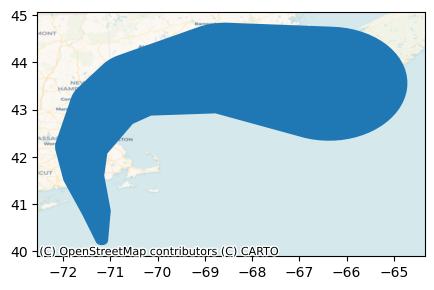

In [91]:
cone = visualizeUncertainty(forecast_circle.to_crs(epsg=4326))
fig, ax = plt.subplots(1, 1, figsize=(5,5))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, )


ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()

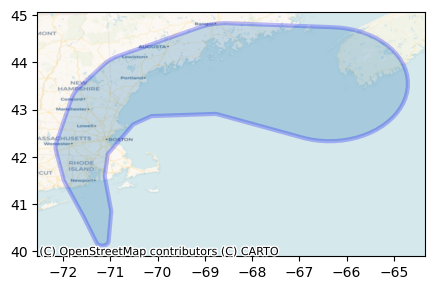

In [92]:
cone = visualizeUncertainty(forecast_circle)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

p = gpd.GeoSeries(cone)
p.plot(ax=ax, alpha= 0.25, edgecolor= "blue", linewidth= 3)


ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )

plt.show()

cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[cone], crs='EPSG:4326')

In [93]:
from shapely.ops import unary_union
polygon_list = forecast_circle.geometry.tolist()
coastline_cone = unary_union(MultiPolygon(polygon_list).convex_hull)
coastline_cone
coastline_cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[coastline_cone], crs='EPSG:4326')
coastline_cone_gdf

,geometry
0,"POLYGON ((-71.17897 40.12899, -71.19211 40.129..."


In [20]:
!pip install shapely geojson

# track shows where the storm actually went in the past
day1_track = gpd.read_file('https://files.bwsi-remote-sensing.net/data/final_2024/day1/day1_track_past.geojson')
day1_track.plot()

# Location of Areas of Interest


In [19]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip -O R1-Hospitals.zip
!unzip R1-Hospitals.zip

--2024-08-02 18:48:51--  https://files.bwsi-remote-sensing.net/data/final/R1-Hospitals.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 34.213.124.230, 52.32.177.214, 54.186.10.246, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|34.213.124.230|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-02 18:48:51 ERROR 404: Not Found.

Archive:  R1-Hospitals.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Hospitals.zip or
        R1-Hospitals.zip.zip, and cannot find R1-Hospitals.zip.ZIP, period.


In [20]:
!wget https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip -O R1-Shelters.zip
!unzip R1-Shelters.zip

--2024-08-02 18:48:51--  https://files.bwsi-remote-sensing.net/data/final/R1-Shelters.zip
Resolving files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)... 54.201.69.220, 52.32.177.214, 54.186.10.246, ...
Connecting to files.bwsi-remote-sensing.net (files.bwsi-remote-sensing.net)|54.201.69.220|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-08-02 18:48:51 ERROR 404: Not Found.

Archive:  R1-Shelters.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of R1-Shelters.zip or
        R1-Shelters.zip.zip, and cannot find R1-Shelters.zip.ZIP, period.


In [21]:
!pip install fiona

In [94]:
import rasterio
import rasterio.plot
import rasterio.merge 
import rasterio.mask
import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
# !pip install fiona
import fiona
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [95]:
#Flood Depth Map, Getting ELevation:
local_tile1_71 = 'n42_w071_1arc_v3.tif'
local_tile2_72 = 'n42_w072_1arc_v3.tif'

In [96]:
def resize_tile(tile_location, rescaling_factor):
    with rasterio.open(tile_location) as src:
        # print profile for reference
        print(f'original profile {src.profile}')
        # calculate new dimensions
        new_height = int(src.height*rescaling_factor) # int() to round to nearest pixel
        new_width = int(src.width*rescaling_factor)
        # pass in new dimensions to out_shape, specify bilinear sampling
        tile = src.read(1, out_shape=(new_height, new_width), 
                       resampling=rasterio.enums.Resampling.bilinear)
        # copy metadata
        tile_profile = src.profile
        # update transform, height, and width entries
        tile_profile['transform'] = src.transform * src.transform.scale((src.width/tile.shape[-1]),
                                                            (src.height/tile.shape[-2]))
        tile_profile['height'] = new_height
        tile_profile['width'] = new_width
        print(f'updated profile {tile_profile}')
        return tile, tile_profile

In [97]:
rescaling_factor = 0.25
tile1, tile1_profile = resize_tile(local_tile1_71, rescaling_factor)
tile2, tile2_profile = resize_tile(local_tile2_72, rescaling_factor)

tile1_profile['driver'] = 'GTiff'
tile2_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif' #WHAT IS THis?
lowres_tile2_loc = 'lowres_tile2.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
    outfile.write(tile1, 1)
with rasterio.open(lowres_tile2_loc, 'w', **tile2_profile) as outfile:
    outfile.write(tile2, 1)
print(tile1.shape, tile2.shape)

original profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -71.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
updated profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 900, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0011114197530864198, 0.0, -71.00013888888888,
       0.0, -0.0011114197530864198, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
original profile {'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -72.00013888888888,
       0.0, -0.0002777777777777778, 43.000138888888884), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
updated profile {'driver'

<Axes: >

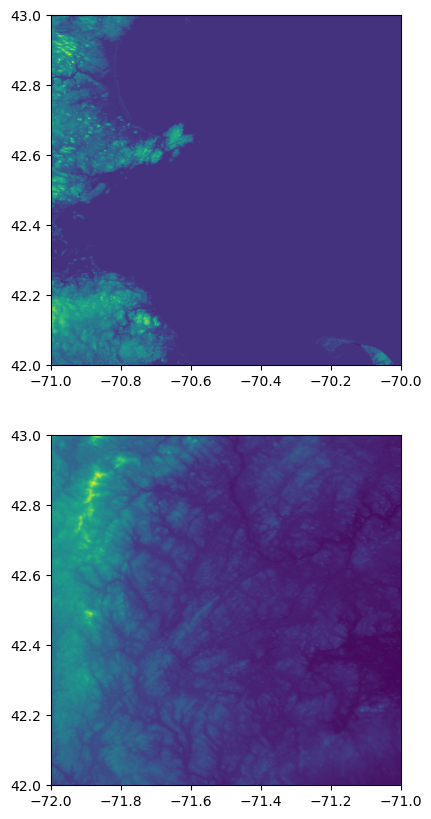

In [98]:
with rasterio.open(lowres_tile1_loc) as src:
    tile1_mask = src.read_masks(1)

with rasterio.open(lowres_tile2_loc) as src:
    tile2_mask = src.read_masks(1)

# we use the np.ma.masked_where() function to mask out all the values equal to zero
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(np.ma.masked_where(tile1_mask==0, tile1), ax=ax1, transform=tile1_profile['transform'])
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(np.ma.masked_where(tile2_mask==0, tile2), ax=ax2, transform=tile2_profile['transform'])

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32767.0, 'width': 1800, 'height': 900, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0011114197530864198, 0.0, -72.00013888888888,
       0.0, -0.0011114197530864198, 43.000138888888884)}


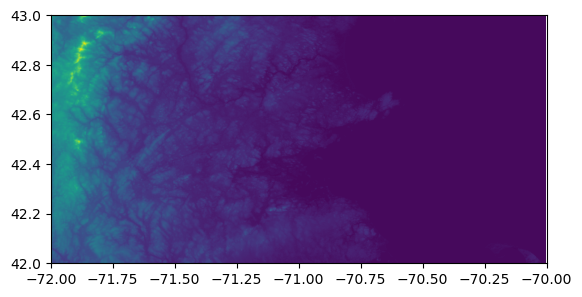

In [99]:
combined_location = 'combined.tif'
with rasterio.open(lowres_tile1_loc, 'r') as src1:
    with rasterio.open(lowres_tile2_loc, 'r') as src2:
        combined, out_transform = rasterio.merge.merge([src1, src2],
                                                       nodata=src2.profile['nodata'])
        combined_meta = src1.profile.copy()
        combined_meta.update({'driver':'GTiff',
                         'count': combined.shape[0],
                        'height': combined.shape[1],
                        'width': combined.shape[2],
                        'transform': out_transform,
                        'crs': src1.crs})
    with rasterio.open(combined_location, 'w', **combined_meta) as dst:
        dst.write(combined) #Write data set to new file
#__________________________________________________________________________________________________

with rasterio.open(combined_location, 'r') as src:
    print(src.meta)
    combined = src.read(1)
    combined_mask = src.read_masks(1)
    combined_transform = src.profile['transform']
    rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                     transform=combined_transform)



In [100]:
# import necessary libraries
import ee
import geemap
ee.Authenticate()
ee.Initialize()

In [101]:
cone_json = shapely.geometry.mapping(cone)
cone_GEE = ee.Feature(cone_json)

coastline_cone_json = shapely.geometry.mapping(coastline_cone)

In [102]:
#vis params because they take too much space
vis_params = {
    'min': -25,            # Minimum value for color scaling
    'max': 700,        # Maximum value for color scaling
    'palette': ['blue', 'green', 'yellow', 'red']  # Color palette (optional)
}

viz_pop = {
    "min": 0.0,
    "max": 1000.0,
    "palette": ["#f7fcf0", "#e0f3f8", "#bfd3c1", "#f4a582", "#d73027"]
}

viz_svi = {
    "min": 0.0,  
    "max": 1.0,  
    "palette": ['blue', 'green', 'yellow', 'purple']  
}


In [103]:
# Load the GeoTIFF as an Earth Engine Image
#DEM1 = ee.Image('projects/geometric-edge-428819-k5/assets/n42_w071_1arc_v3')
#DEM2 = ee.Image('projects/geometric-edge-428819-k5/assets/n42_w071_1arc_v3')
svi = ee.Image('projects/geometric-edge-428819-k5/assets/svi_2020_tract_overall_wgs84')
pop_dataset = ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Count").first()
pop_density = ee.ImageCollection('CIESIN/GPWv411/GPW_Population_Density').first()
coastline = gpd.read_file('ne_50m_coastline.shp')
cropped_coastline = gpd.overlay(coastline, coastline_cone_gdf, how='intersection')
cropped_coastline.geometry.buffer(5000)

ee_coastline = geemap.gdf_to_ee(cropped_coastline)
pop_raster = pop_dataset.select("population_count")
# If you want to visualize the feature, you can use geemap.
Map = geemap.Map()
#Map.addLayer(DEM1, vis_params, 'tile-1')
#Map.addLayer(DEM2, vis_params, 'tile-2')
Map.addLayer(ee_coastline, {}, "coastline")
Map.addLayer(pop_raster, viz_pop, "Population")#population
Map.addLayer(pop_raster, viz_pop, "Population Density")#population per square kilometer.
Map.addLayer(svi, viz_svi, 'SVI Data')
Map.addLayer(cone_GEE, {}, 'Polygon')
Map.centerObject(cone_GEE, 10)
Map

Map(center=[43.3512621901889, -68.51662866780617], controls=(WidgetControl(options=['position', 'transparent_b…

In [104]:
product_svi = {
    "min": 0.0,  
    "max": 3000,  
    "palette": ['blue', 'green', 'yellow', 'red']  
}


In [105]:
print(type(cone_GEE))

roi = cone_GEE

pop_mask = pop_raster.clip(roi)
#create df and add 0 to all columns
df_pop_test = pd.DataFrame(1.5 * np.arange(1, 10), columns=['pops'])
df_pop_test['svi'] = 0.0

index = 0
# Get the projection of pop_mask.
projection = pop_mask.select(0).projection()
scale = projection.nominalScale().getInfo()

for svi_threshold in np.arange(1, 0, -0.025):
    svi_mask = svi.gt(svi_threshold).clip(roi)
    
    # Reproject svi_mask to match the resolution and projection of image1.
    svi_mask = svi_mask.reproject(projection)
    
    pop_impacted = svi_mask.multiply(pop_mask)
    
    # Apply the reducer to get the sum of all values.
    reduction = pop_impacted.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=pop_impacted.geometry(),
        scale=scale,
        maxPixels=1e9
    )
    
    # Get the sum of all values for the band 'b1'.
    sum_value = round(reduction.get('b1').getInfo()/1e6, 3)

    if sum_value >= df_pop_test.at[index, 'pops']:
        print(f"svi: {svi_threshold} Sum of pops: {sum_value} Million")
        df_pop_test.at[index, 'svi']= svi_threshold
        index = index + 1
        if index > len(df_pop_test):
            break
df_pop_test = df_pop_test[df_pop_test.svi > 0]
df_pop_test

<class 'ee.feature.Feature'>
svi: 0.6249999999999997 Sum of pops: 1.505 Million
svi: 0.37499999999999944 Sum of pops: 3.215 Million
svi: 0.24999999999999933 Sum of pops: 4.633 Million
svi: 0.12499999999999922 Sum of pops: 6.026 Million


,pops,svi
0,1.5,0.625
1,3.0,0.375
2,4.5,0.250
3,6.0,0.125


In [106]:
# def mask_to_polygons(image):
#     xmin = -72.0  # Longitude (West)
#     ymin = 40.0   # Latitude (South)
#     xmax = -70.0  # Longitude (East)
#     ymax = 44.0   # Latitude (North)


# # Create the ROI as an ee.Geometry.Rectangle in EPSG:4326
#     poi = ee.Geometry.Rectangle([xmin, ymin, xmax, ymax])
#         polygons = image.reduceToVectors(
#         reducer=ee.Reducer.countEvery(),
#         scale=30,  # Define scale, adjust if needed
#         geometry=poi,  # Define ROI
#         geometryType='polygon',
#         labelProperty='count'
#     )
#     return polygons

# # Convert to polygons
# evac_polygon = mask_to_polygons(evac_zone)

In [109]:
Map3 = geemap.Map()


evac_zone = svi.gt(0.062499).And(svi.lt(2)).clip(roi)
Map3.addLayer(evac_zone, {}, "0.62")
evac_zone = svi.gt(0.374).And(svi.lt(0.62499)).clip(roi)
Map3.addLayer(evac_zone, {}, "0.45")
evac_zone = svi.gt(0.).And(svi.lt(2)).clip(roi)
Map3.addLayer(evac_zone, {}, "0.3")
evac_zone = svi.gt(0.2).lt(0.3).clip(roi)
Map3.addLayer(evac_zone, {}, "0.2")
evac_zone = svi.gt(0.1).lt(0.2).clip(roi)
Map3.addLayer(evac_zone, {}, "0.1")

Map3

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [51]:
japan = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017').filter(
    ee.Filter.eq('country_na', 'Japan')
)

# Load a 2012 nightlights image, clipped to the Japan border.
nl_2012 = (
    ee.Image('NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182012')
    .select('stable_lights')
    .clipToCollection(japan)
)

# Define arbitrary thresholds on the 6-bit nightlights image.
zones = nl_2012.gt(30).add(nl_2012.gt(55)).add(nl_2012.gt(62))
zones = zones.updateMask(zones.neq(0))

# Convert the zones of the thresholded nightlights to vectors.
vectors = evac_zone.reduceToVectors(
    geometry=japan,
    crs=nl_2012.projection(),
    scale=1000,
    geometryType='polygon',
    eightConnected=False,
    labelProperty='zone',
    reducer=ee.Reducer.mean(),
)

# Display the thresholds.
m = geemap.Map()
m.set_center(139.6225, 35.712, 9)
m.add_layer(
    zones,
    {'min': 1, 'max': 3, 'palette': ['0000FF', '00FF00', 'FF0000']},
    'raster',
)

# Make a display image for the vectors, add it to the map.
display_image = ee.Image(0).updateMask(0).paint(vectors, '000000', 3)
m.add_layer(display_image, {'palette': '000000'}, 'vectors')
m

EEException: Image.reduceToVectors: Need 1+1 bands for Reducer.mean, image has 1.

In [52]:
reduction = pop_impacted.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=pop_impacted.geometry(),
    scale=scale,
    maxPixels=1e9
)

# Get the minimum value for the band 'B4'.
min_value = reduction.get('b1').getInfo()
print(min_value)

0


In [53]:
Map2 = geemap.Map()
Map2.addLayer(pop_mask, viz_pop, "Population")
Map2.addLayer(svi_mask, {}, "svi")
Map2.addLayer(cone_GEE)
Map2.addLayer(pop_impacted, {"min": 10,   "max": 3000,   "palette": ['blue', 'green', 'yellow', 'red']  }, "pop_impacted")
Map2

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [54]:
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(
    '2021-05-01', '2021-06-01'
)


# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )


dataset = dataset.map(apply_scale_factors)
dataset = dataset.median()
visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

palette = {'palette':['brown', 'yellow', 'lightgreen', 'green', 'blue'], 'min': 0, 'max': 1}
ndmi = dataset.normalizedDifference(['SR_B5', 'SR_B6']).rename('NDSI')

m = geemap.Map()
m.set_center(-114.2579, 38.9275, 8)
m.add_layer(dataset, visualization, 'True Color (432)')
m.addLayer(ndmi, palette , "moist moist moist")
m

Map(center=[38.9275, -114.2579], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [111]:
population_image = ee.Image('JRC/GHSL/P2016/POP_GPW_GLOBE_V1/2015')
srtm_data = ee.Image('USGS/SRTMGL1_003')
terrain_data = ee.Algorithms.Terrain(srtm_data)
slope_image = terrain_data.select('slope')
slope_mask = slope_image.lt(5)
svi_image = ee.Image('projects/nikhil-bwsi/assets/svi_2020_tract_overall_wgs84')
svi_threshold = 0.5
svi_mask = svi_image.gt(svi_threshold)
combined_mask = slope_mask.And(svi_mask)

evac_area = gpd.read_file("evac_poly_guess.geojson")
# evac_area2 = ee.Feature(unary_union(evac_area.geometry))

ee_geometry = gdf_to_ee_geometry(evac_area)

print(type(evac_area))
clipped_population = population_image.clip(cone_GEE.geometry())
masked_population = clipped_population.updateMask(combined_mask)
population_stats = masked_population.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=ee_geometry,
    scale=250,
    maxPixels=1e9
)





#population_count = population_stats.get('population_count').getInfo()
#rounded_population_count = round(population_count)
#print(f'Estimated population inside the cone with slopes less than 5% and SVI below {svi_threshold}:\n{rounded_population_count}')

NameError: name 'gdf_to_ee_geometry' is not defined

In [57]:
from rasterio.mask import mask
cone_gdf = gpd.GeoDataFrame(index=[0], geometry=[cone], crs='EPSG:4326')
geometries = cone_gdf.geometry.values
out_image, out_transform = mask(src, geometries, crop=True)

RasterioIOError: Dataset is closed: combined.tif

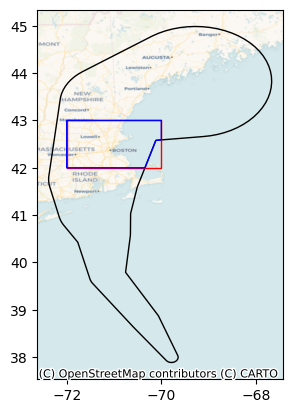

In [58]:
from rasterio.mask import mask
from shapely.geometry import box
# Load the TIFF file
tiff_path = 'combined.tif'
with rasterio.open(tiff_path) as src:
    # Get the bounding box of the TIFF file
    tiff_bounds = src.bounds
    
    # Get the CRS of the TIFF
    tiff_crs = src.crs

# Create a shapely polygon from the bounding box
tiff_polygon = box(tiff_bounds.left, tiff_bounds.bottom, tiff_bounds.right, tiff_bounds.top)

# Reproject the GeoDataFrame to match the CRS of the TIFF, if needed

# Perform intersection between each polygon in the GeoDataFrame and the TIFF polygon
intersections = cone_gdf.geometry.intersection(tiff_polygon)

# Create a new GeoDataFrame from the intersections
intersected_gdf = gpd.GeoDataFrame(geometry=intersections, crs=cone_gdf.crs)

# Save the intersected GeoDataFrame to a new shapefile
intersected_gdf.to_file('pleasework.shp')

# Optional: Visualize the result
ax = cone_gdf.plot(edgecolor='black', facecolor='none')
gpd.GeoSeries([tiff_polygon]).plot(ax=ax, edgecolor='red', facecolor='none')
intersected_gdf.plot(ax=ax, edgecolor='blue', facecolor='none')
ctx.add_basemap(ax,
               crs=forecast_circle.crs,
               source=ctx.providers.CartoDB.Voyager
              )
plt.show()

In [59]:
cone_gdf.to_file("cone_day_1.geojson", driver="GeoJSON")